# Predicting the cost of health insurance for a person

## Problem Statement

The important insurance company 4Geeks Insurance S.L. wants to calculate, based on physiological data of its customers what will be the premium (cost) to be borne by each of them. To do this, it has assembled a whole team of doctors and based on data from other companies and a particular study have managed to gather a set of data to train a predictive model.

## Dictionary

**age:** Age of primary beneficiary (numeric) <br/>
**sex:** Gender of the primary beneficiary (categorical) <br/>
**bmi:** Body mass index (numeric) <br/>
**children:** Number of children/dependents covered by health insurance (numeric) <br/>
**smoker:** smoker (categorical) <br/>
**region:** Beneficiary's residential area in the U.S.: northeast, southeast, southwest, northwest (categorical) <br/>
**charges:** Health insurance premium (numerical)

In [16]:
# Library Importings
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")

raw_df.to_csv("../data/raw/raw_df.csv")

raw_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [5]:
raw_df.duplicated().sum()

1

In [6]:
processed_df = raw_df.drop_duplicates().reset_index(drop = True).copy()
processed_df.duplicated().sum()

0

In [7]:
processed_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
processed_df.drop("charges", axis = 1).isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

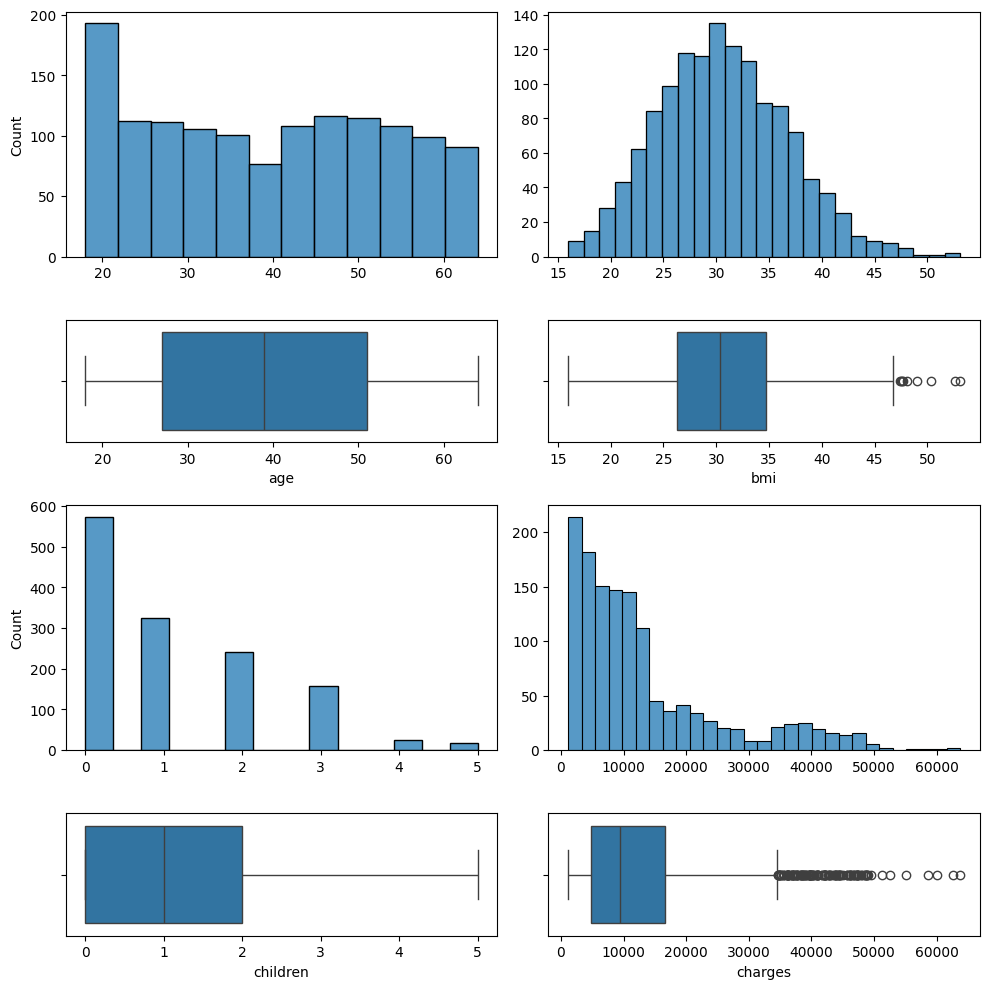

In [9]:
fig, axis = plt.subplots(4, 2, figsize = (10, 10), gridspec_kw={'height_ratios': [4,2,4,2]})

sns.histplot(ax = axis[0, 0], data = processed_df, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = processed_df, x = "age")
sns.histplot(ax = axis[0, 1], data = processed_df, x = "bmi").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = processed_df, x = "bmi")
sns.histplot(ax = axis[2, 0], data = processed_df, x = "children").set(xlabel = None)
sns.boxplot(ax = axis[3, 0], data = processed_df, x = "children")
sns.histplot(ax = axis[2, 1], data = processed_df, x = "charges").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 1], data = processed_df, x = "charges")

plt.tight_layout()

plt.show()

In [10]:
# Scaling using Min-Max

processed_df["sex_n"] = pd.factorize(processed_df["sex"])[0]
processed_df["smoker_n"] = pd.factorize(processed_df["smoker"])[0]
processed_df["region_n"] = pd.factorize(processed_df["region"])[0]
num_variables = ["age", "bmi", "children", "sex_n", "smoker_n", "region_n", "charges"]

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(processed_df[num_variables])
processed_df_scal = pd.DataFrame(scal_features, index = processed_df.index, columns = num_variables)
processed_df_scal.head()

,age,bmi,children,sex_n,smoker_n,region_n,charges
0,0.021739,0.321227,0.0,0.0,0.0,0.000000,0.251611
1,0.000000,0.479150,0.2,1.0,1.0,0.333333,0.009636
2,0.217391,0.458434,0.6,1.0,1.0,0.333333,0.053115
3,0.326087,0.181464,0.0,1.0,1.0,0.666667,0.333010
4,0.304348,0.347592,0.0,1.0,1.0,0.666667,0.043816


In [11]:
# Feature selection

X = processed_df_scal.drop("charges", axis = 1)
y = processed_df_scal["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

selected_columns = X_train.columns[selection_model.get_support()]
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = selected_columns)
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = selected_columns)

X_train_sel.head()

,age,bmi,children,smoker_n
0,0.108696,0.230024,0.0,1.0
1,0.065217,0.263250,0.4,1.0
2,0.739130,0.580172,0.4,1.0
3,0.978261,0.686306,0.0,1.0
4,0.630435,0.286252,0.4,1.0


In [12]:
X_train_sel["charges"] = y_train.values
X_test_sel["charges"] = y_test.values
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)

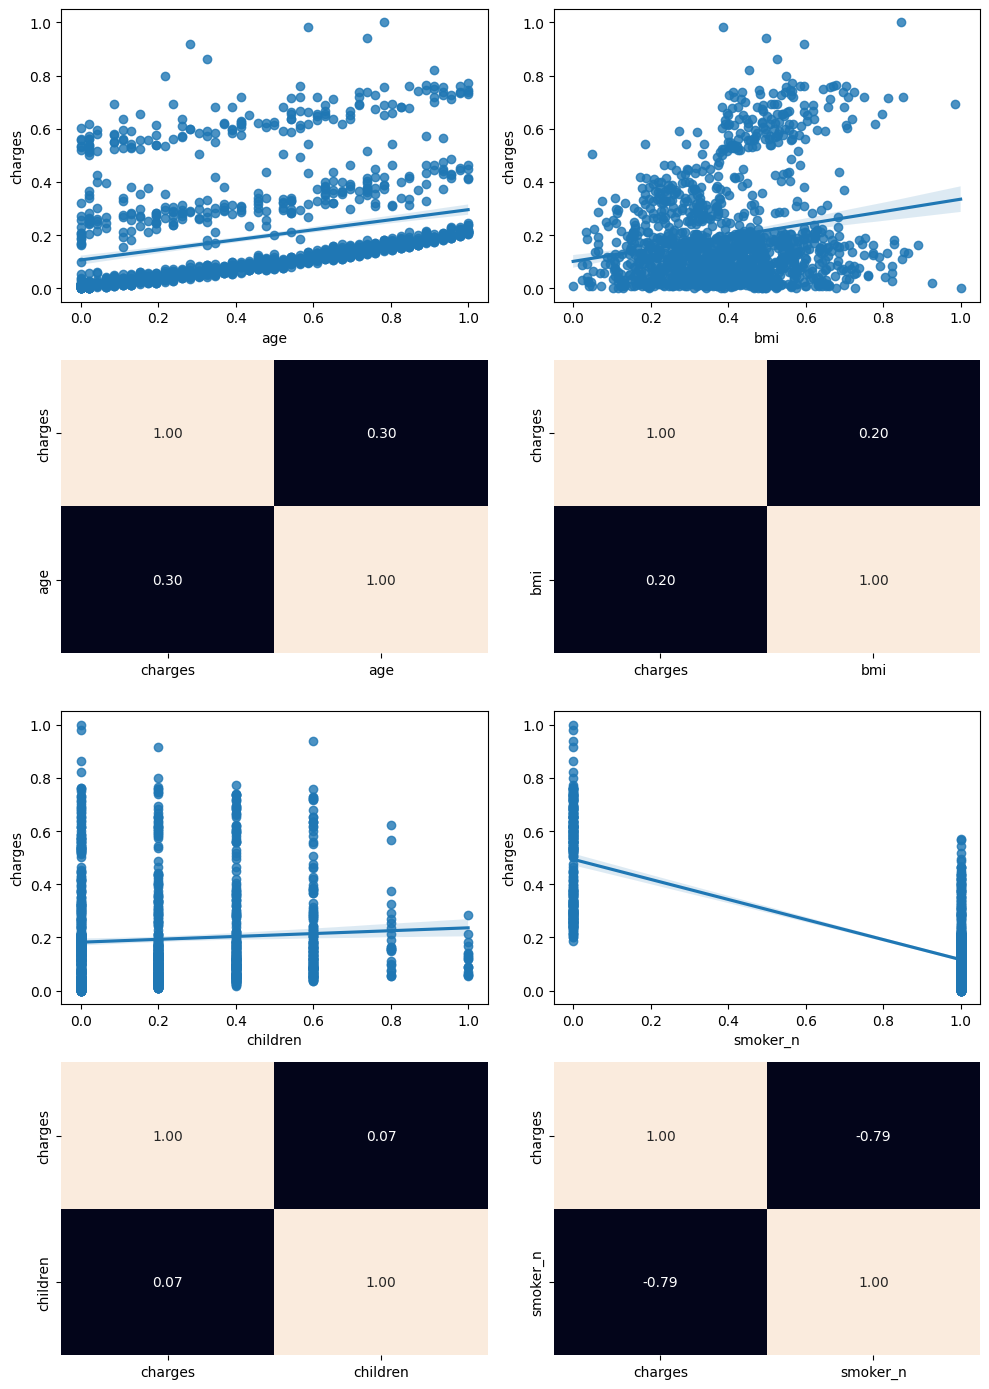

In [13]:
fig, axis = plt.subplots(4, 2, figsize = (10, 14))
processed_df = pd.concat([X_train_sel, X_test_sel])

sns.regplot(data = processed_df, x = "age", y = "charges", ax = axis[0, 0])
sns.heatmap(processed_df[["charges", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(data = processed_df, x = "bmi", y = "charges", ax = axis[0, 1])
sns.heatmap(processed_df[["charges", "bmi"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1], cbar = False)

sns.regplot(data = processed_df, x = "children", y = "charges", ax = axis[2, 0])
sns.heatmap(processed_df[["charges", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0], cbar = False)

sns.regplot(data = processed_df, x = "smoker_n", y = "charges", ax = axis[2, 1])
sns.heatmap(processed_df[["charges", "smoker_n"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1], cbar = False)

plt.tight_layout()
plt.show()

In [14]:
X_train = X_train_sel.drop(["charges"], axis = 1)
y_train = X_train_sel["charges"]
X_test = X_test_sel.drop(["charges"], axis = 1)
y_test = X_test_sel["charges"]

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
print(f"Slope: {model.intercept_}")
print(f"Coefficients (b1, b2): {model.coef_}")

Slope: 0.3195827183308947
Coefficients (b1, b2): [ 0.1829699   0.18111814  0.04293572 -0.36780589]


In [17]:
y_pred = model.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

MSE: 0.009150574110331995
R2 Score: 0.8045531086669288
